In [1]:
import os
Root = "/content/drive/MyDrive/GTSR"
os.chdir(Root)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 2.x

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(870383)

from matplotlib import style
style.use('fivethirtyeight')

In [5]:
data_dir = "/content/drive/MyDrive/GTSR"
train_path = 'Train'
test_path = 'Test'

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels =3 

In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

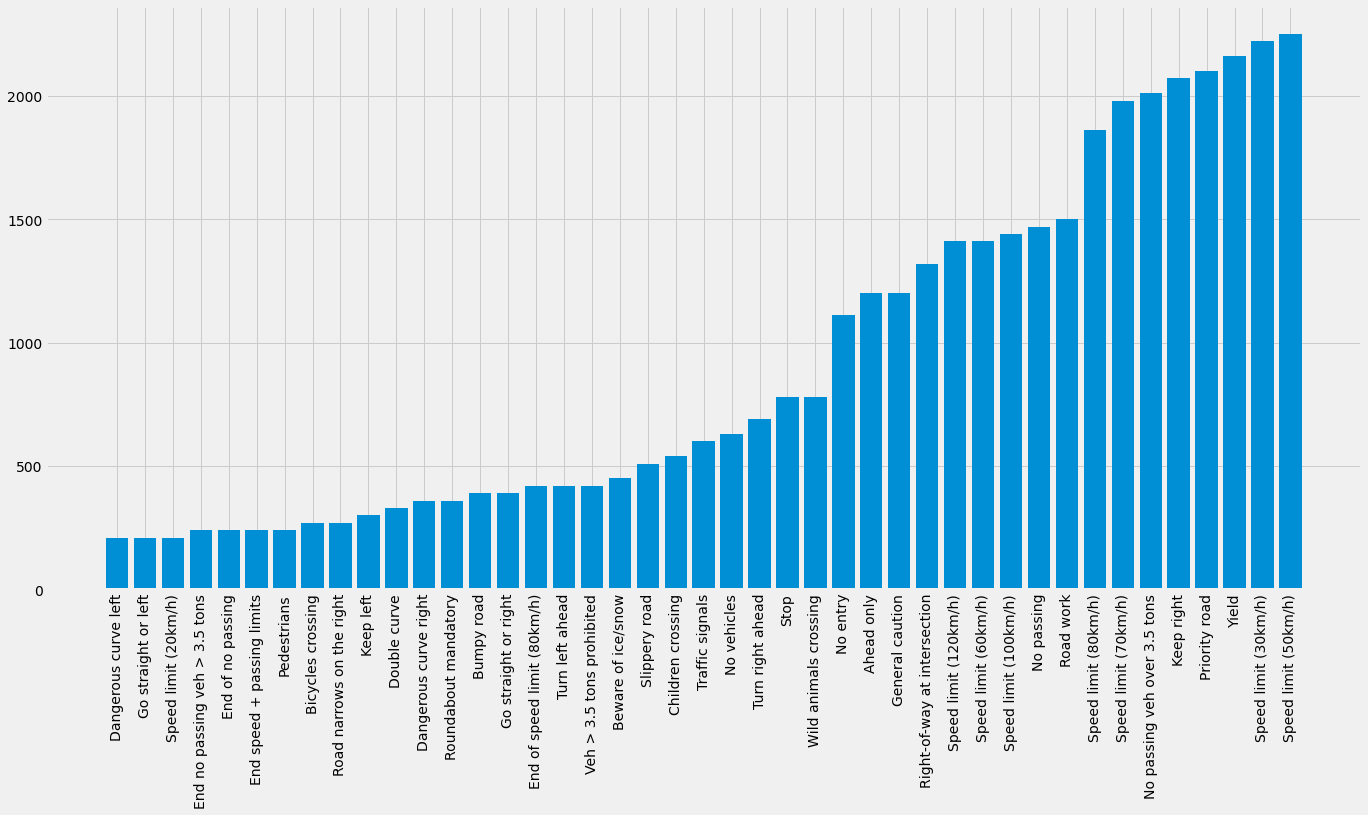

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

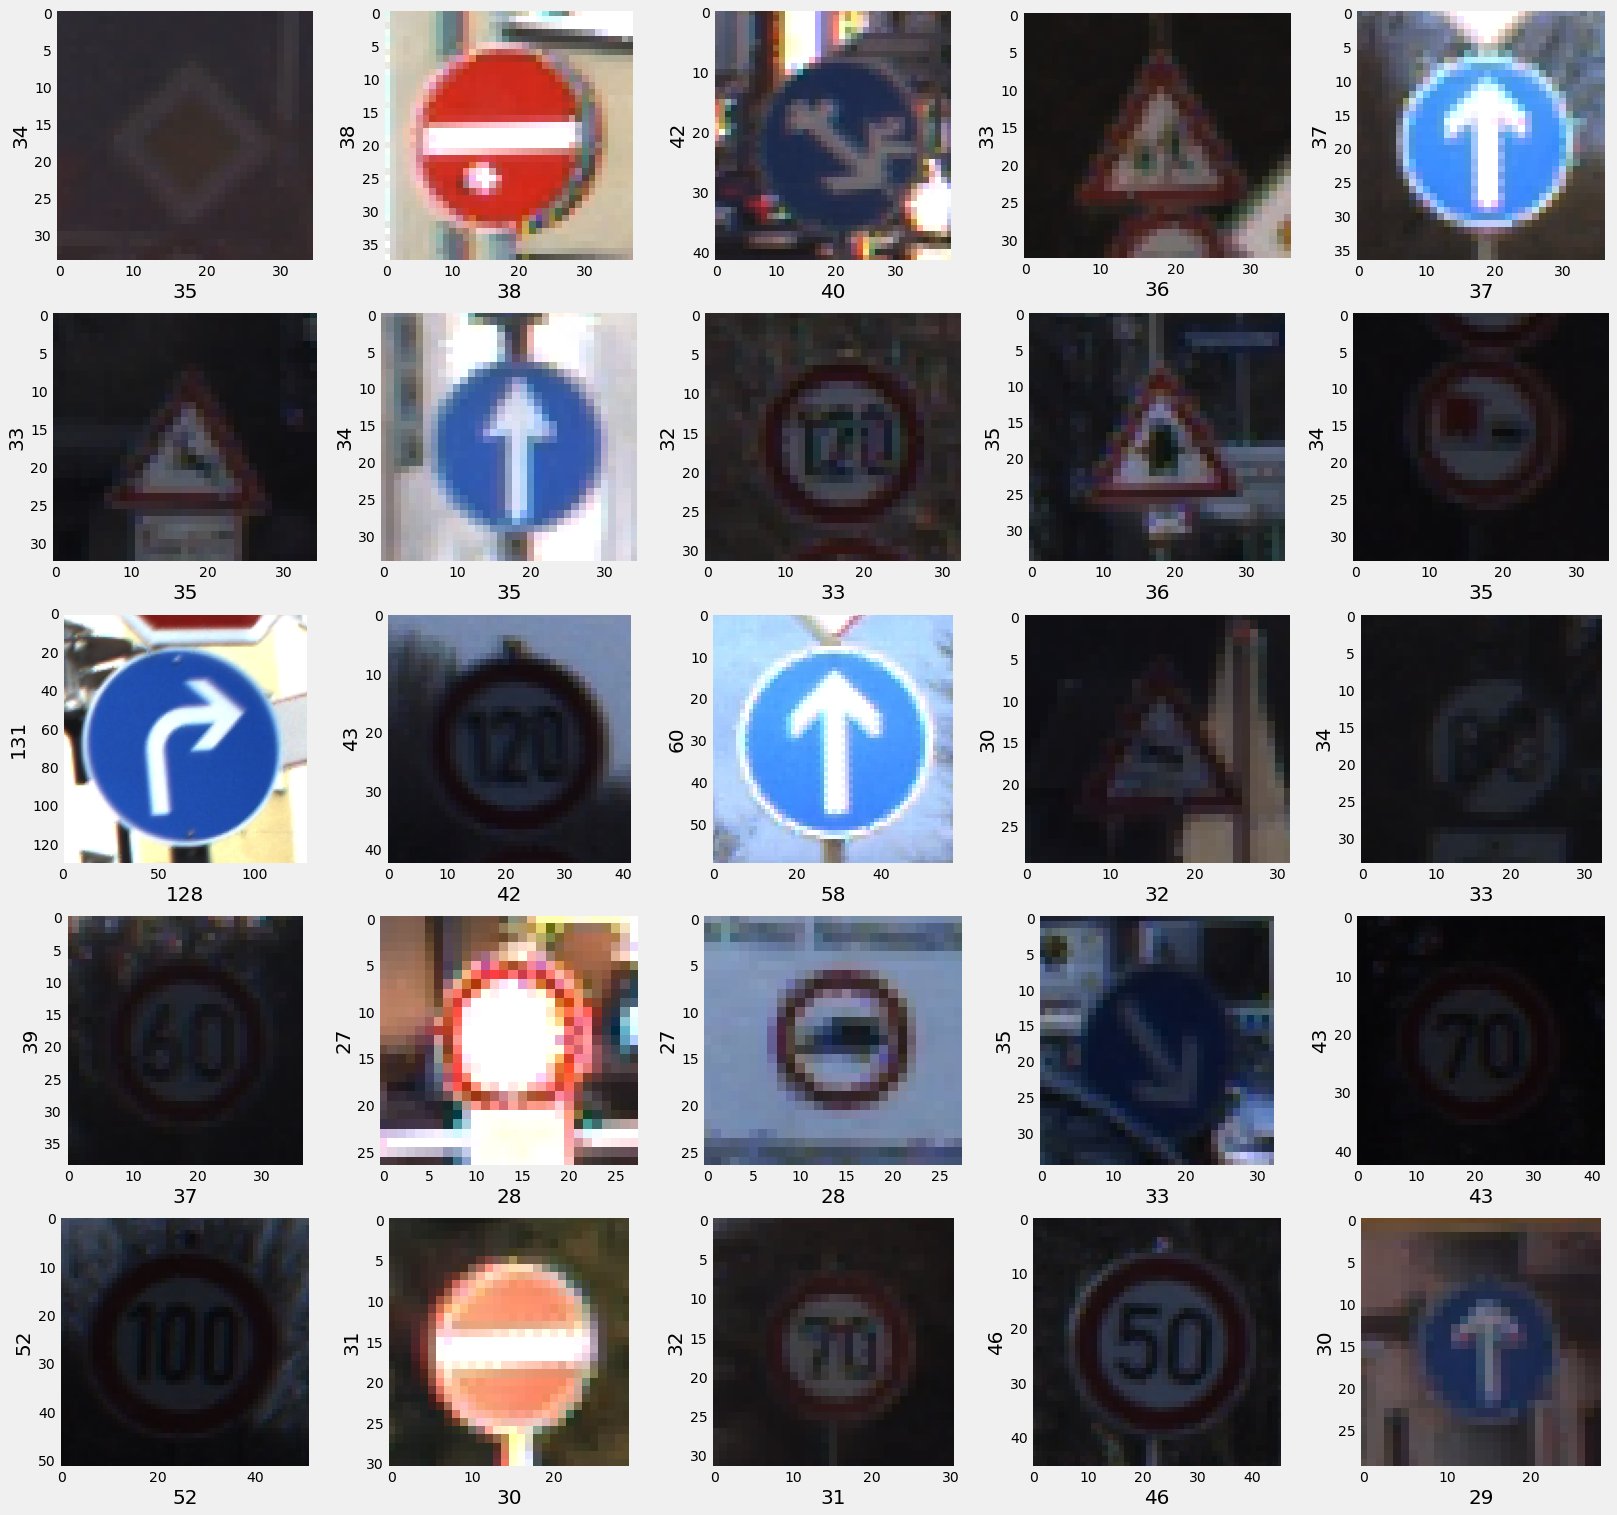

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('/content/drive/MyDrive/GTSR/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [ ]:
from tensorflow.python import keras
from keras.utils import np_utils
y_train = keras.utils.np_utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.np_utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [ ]:
from keras.regularizers import l2

cnn_qsvm = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    

    keras.layers.Flatten(),
    keras.layers.Dense(512),
    keras.layers.Activation(activation='relu'),
    keras.layers.Dropout(rate=0.5),
    ##SVM part 
    keras.layers.Dense(units=43,activity_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.Activation(activation='linear')
])

In [ ]:
 ##SVM part 
cnn_qsvm.compile(optimizer= 'adam' , loss= keras.losses.hinge, metrics=['accuracy'])


In [ ]:
historysvm=cnn_qsvm.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, validation_data=(X_val, y_val))

Epoch 1/30
687/687 [==============================] - 67s 96ms/step - loss: 0.5940 - accuracy: 0.1060 - val_loss: 0.4870 - val_accuracy: 0.1428
Epoch 2/30
687/687 [==============================] - 65s 95ms/step - loss: 0.5037 - accuracy: 0.1380 - val_loss: 0.4849 - val_accuracy: 0.1885
Epoch 3/30
687/687 [==============================] - 65s 95ms/step - loss: 0.4883 - accuracy: 0.1831 - val_loss: 0.4772 - val_accuracy: 0.2641
Epoch 4/30
687/687 [==============================] - 66s 96ms/step - loss: 0.4768 - accuracy: 0.2564 - val_loss: 0.4701 - val_accuracy: 0.4107
Epoch 5/30
687/687 [==============================] - 66s 96ms/step - loss: 0.4678 - accuracy: 0.3746 - val_loss: 0.4596 - val_accuracy: 0.6160
Epoch 6/30
687/687 [==============================] - 66s 96ms/step - loss: 0.4617 - accuracy: 0.4918 - val_loss: 0.4550 - val_accuracy: 0.6667
Epoch 7/30
687/687 [==============================] - 66s 95ms/step - loss: 0.4598 - accuracy: 0.5218 - val_loss: 0.4545 - val_accuracy:

In [ ]:
cnn_qsvm.save("cnn_qsvm.h5")

In [ ]:
cnn_qsvm.save_weights("/content/drive/MyDrive/GTSR/outputSVM")

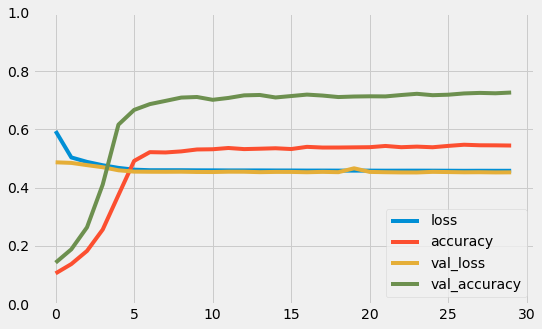

In [ ]:
pd.DataFrame(historysvm.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = cnn_qsvm.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test Data accuracy:  73.51543942992875


In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

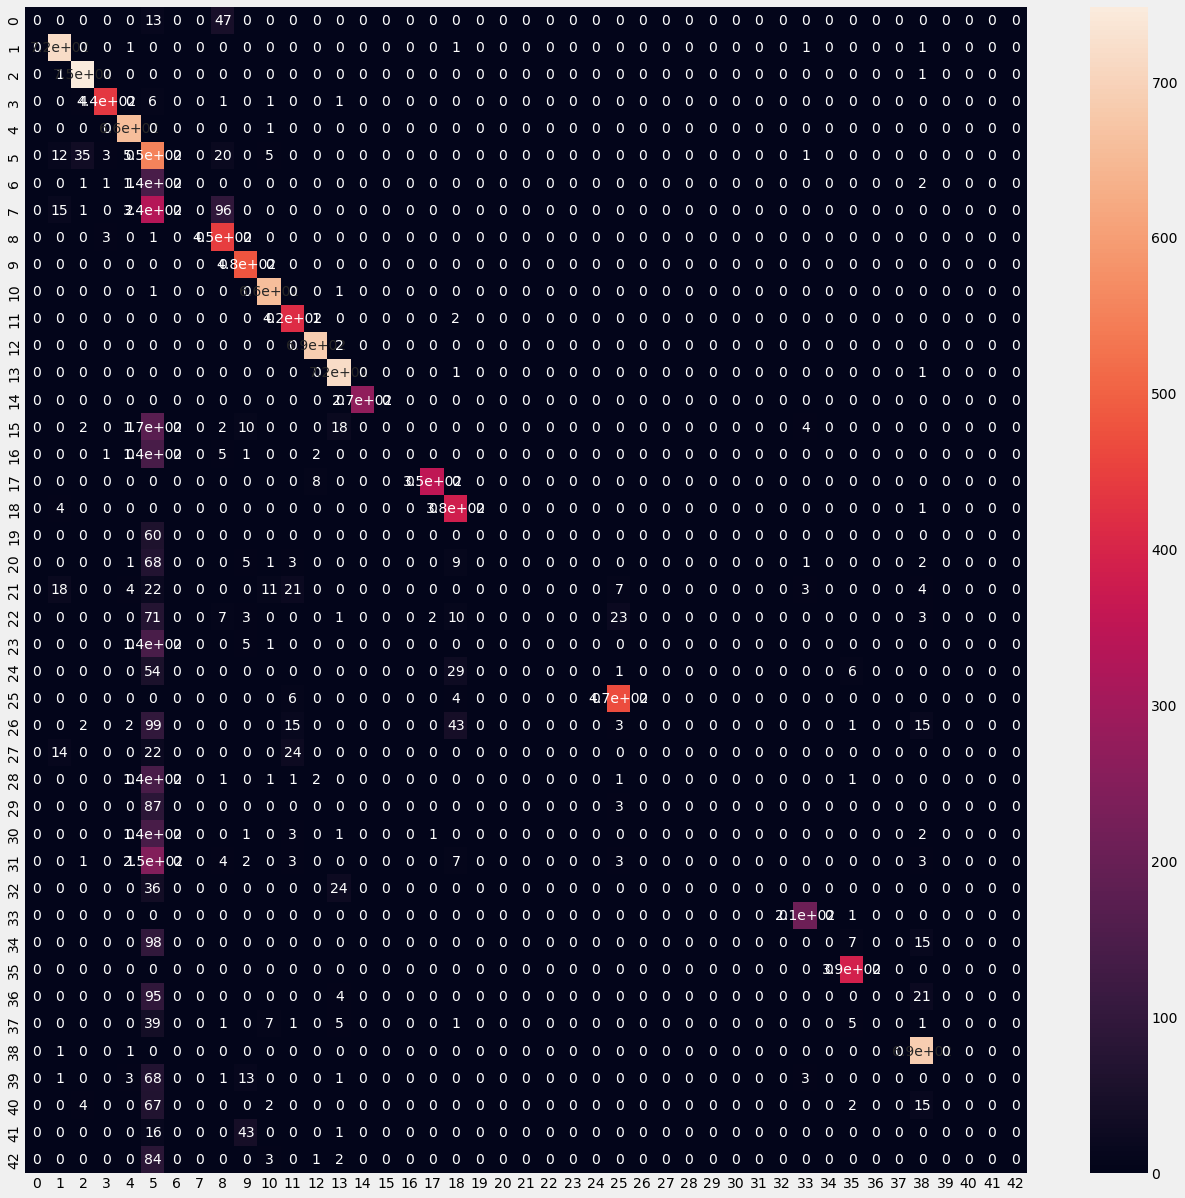

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

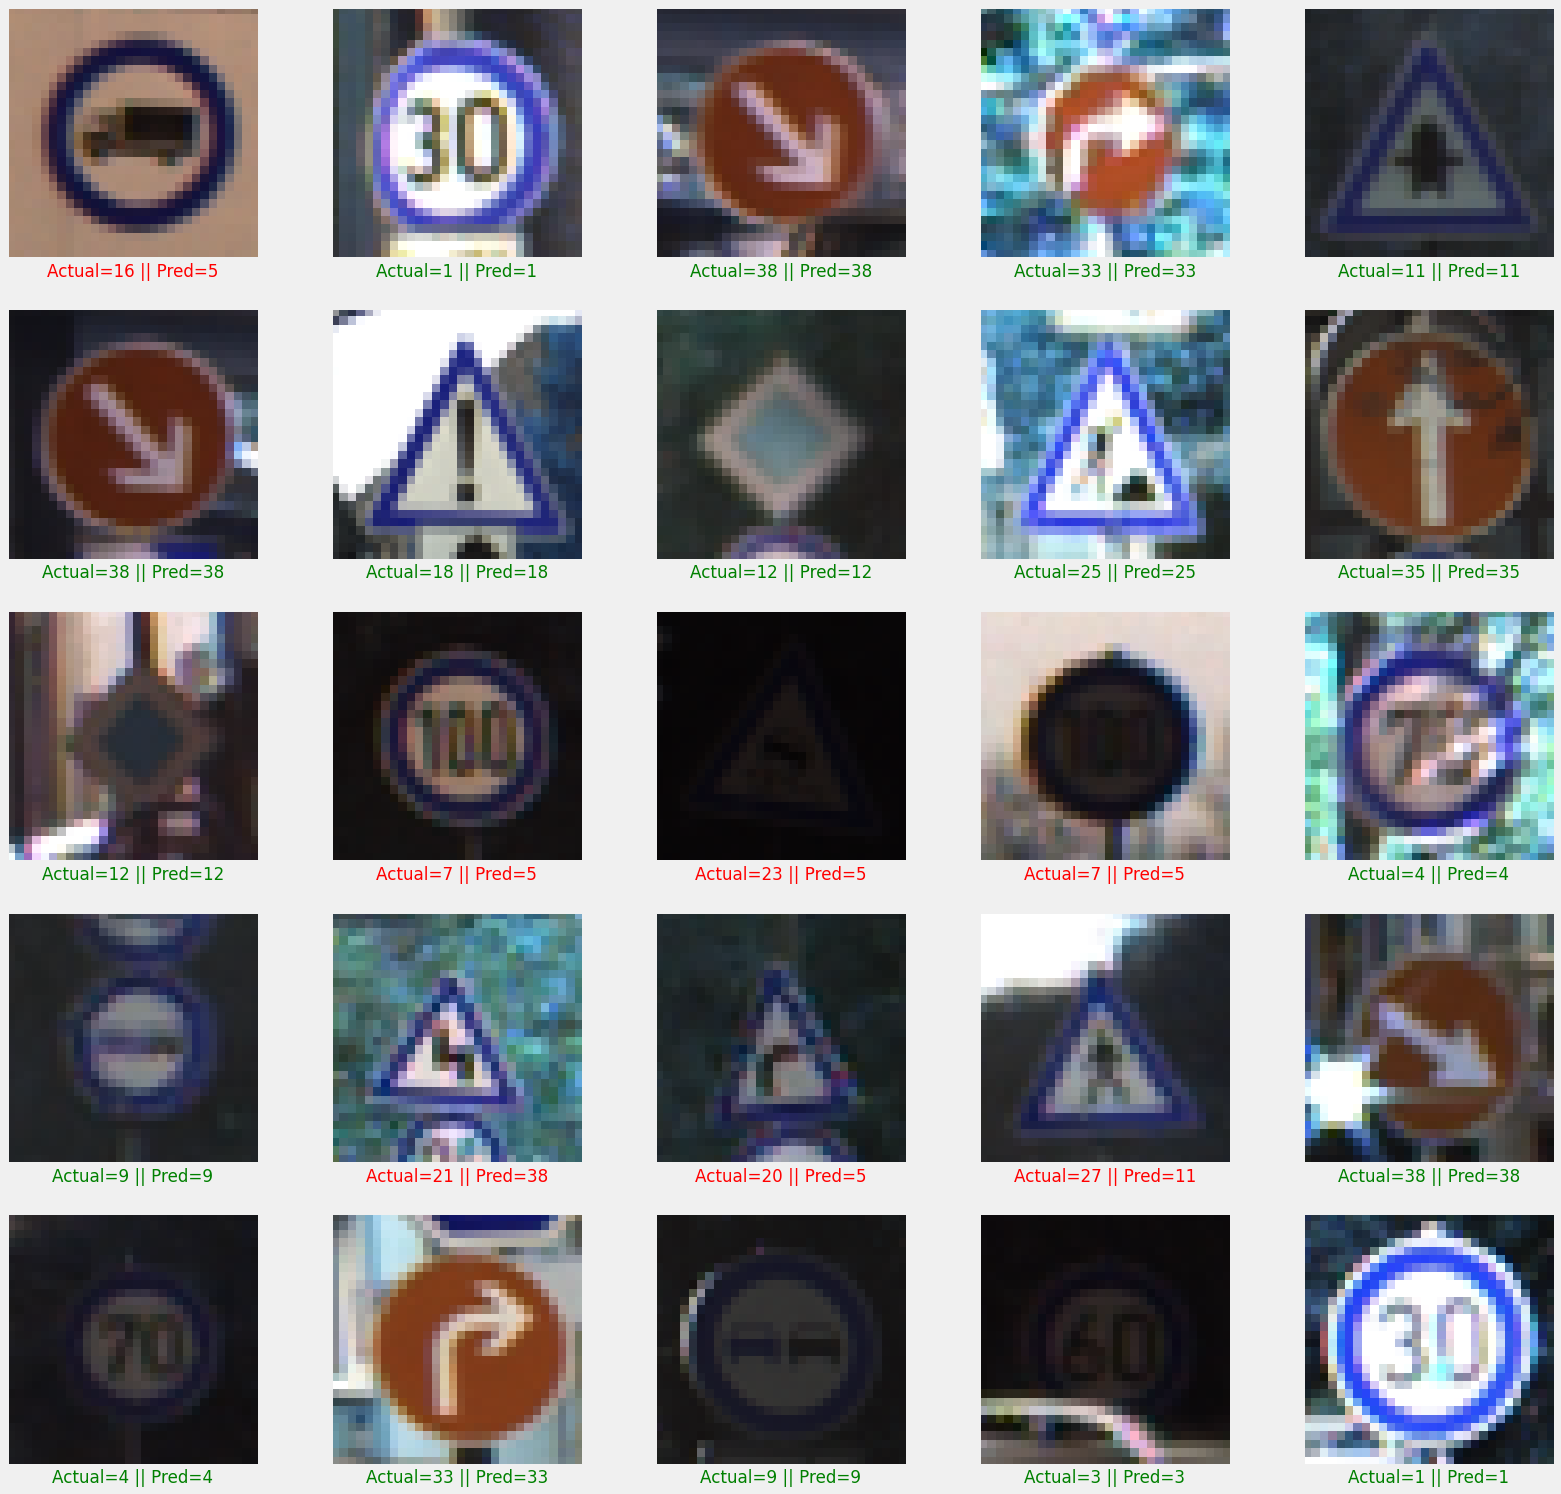

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

5

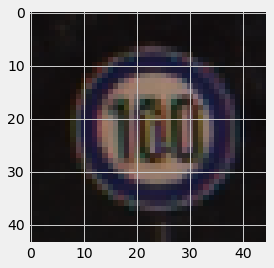

In [8]:
model_path = "cnn_qsvm.h5"
loaded_model = tf.keras.models.load_model(model_path)


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image = cv2.imread("/content/drive/MyDrive/GTSR/Test/00011.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
plt.imshow(image)
result